In [1]:
import json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

### In the wild dataset

In [122]:
def find_unique_authors_create_dataFrame(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    unique_authors = set()
    authors_list = []
    ids_list = []
    quotes_list = []
    labels_list = []
    author_id_map = {}
    current_id = 0
    for item in data:
        author = item.get('speaker')
        if author:
            if author not in author_id_map:
                    author_id_map[author] = current_id
                    current_id += 1
            unique_authors.add(author)
            authors_list.append(author)
            ids_list.append(author_id_map[author])
            quotes_list.append(item.get('content'))
            labels_list.append(item.get('label'))
    data = pd.DataFrame({
        'label': ids_list,
        'author_name': authors_list,
        'text': quotes_list,
        'type': labels_list,
        'length': [len(quote) for quote in quotes_list]
    })
    data['author_name'] = data['author_name'].replace('JFK', 'John F. Kennedy').replace('FDR', 'Franklin D. Roosevelt').replace('Harry Truman', 'Harry S. Truman').replace('Mr. Rogers','Fred Rogers')
    author_id_map['John F. Kennedy'] = author_id_map.pop('JFK')
    author_id_map['Franklin D. Roosevelt'] = author_id_map.pop('FDR')
    author_id_map['Harry S. Truman'] = author_id_map.pop('Harry Truman')
    author_id_map['Fred Rogers'] = author_id_map.pop('Mr. Rogers')
    return unique_authors, data, author_id_map

In [6]:
def plot_author_quotes_count(data):
    quote_counts = data['author_name'].value_counts()
    plt.figure(figsize=(10, 8))
    quote_counts.plot(kind='bar', color=plt.cm.viridis(np.linspace(0, 1, len(quote_counts))))
    plt.title('Number of Quotes per Author')
    plt.xlabel('Author')
    plt.ylabel('Number of Quotes')
    plt.xticks(rotation=90)
    plt.show()
    return quote_counts

In [124]:
json_file_path = '../Data/InTheWild/wild_transcription_meta.json'
unique_authors, data, author_id_map = find_unique_authors_create_dataFrame(json_file_path)

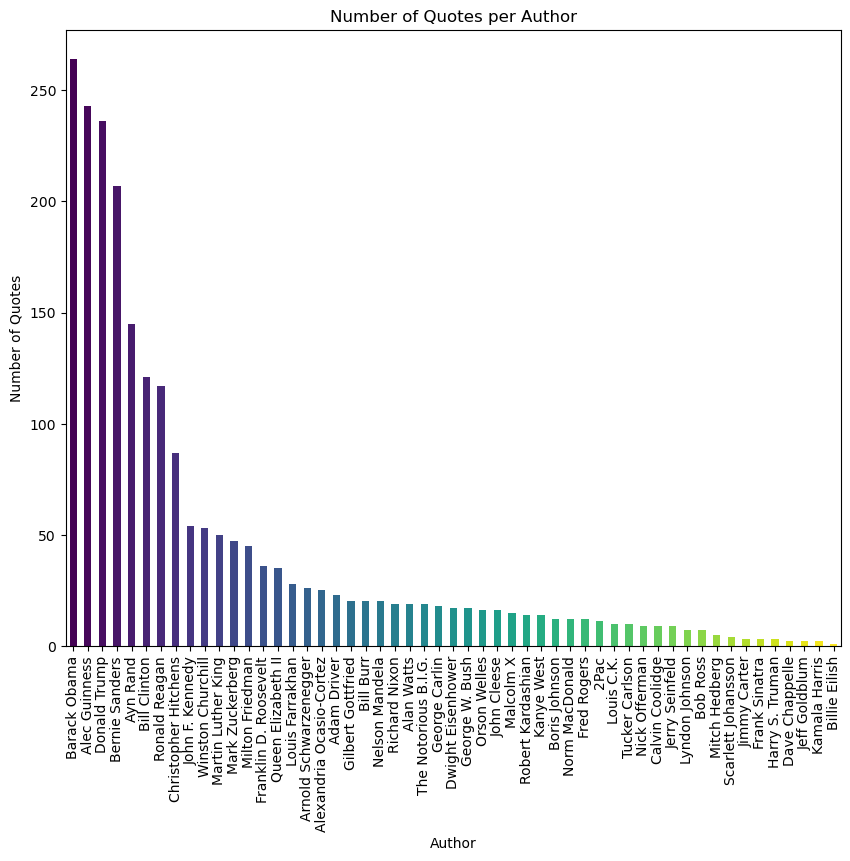

In [125]:
quotes_count = plot_author_quotes_count(data[data['length'] > 20])

### Wikiquotes

In [126]:
import os
folder_path = '../Data/WikiQuotes'
metadata_file = os.path.join(folder_path, 'quotes-500-en-sources.csv')
metadata_df = pd.read_csv(metadata_file)
quotes_file = os.path.join(folder_path, 'quotes-500-en-quotes.csv')
quotes_df = pd.read_csv(quotes_file)
filtered_quotes_df = quotes_df[quotes_df['source_id'].isin(metadata_df[metadata_df['name'].isin(author_id_map.keys())]['source_id'])]
source_id_to_name = dict(zip(metadata_df['source_id'], metadata_df['name']))
filtered_quotes_df['author_name'] = filtered_quotes_df['source_id'].map(source_id_to_name)
new_data = pd.DataFrame({
    'label': filtered_quotes_df['author_name'].map(author_id_map),
    'author_name': filtered_quotes_df['author_name'],
    'text': filtered_quotes_df['quote'],
    'type': 'bona-fide',
    'length': filtered_quotes_df['quote'].apply(len)
})

data = pd.concat([data, new_data], ignore_index=True)


/tmp/ipykernel_184401/2683164703.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_quotes_df['author_name'] = filtered_quotes_df['source_id'].map(source_id_to_name)


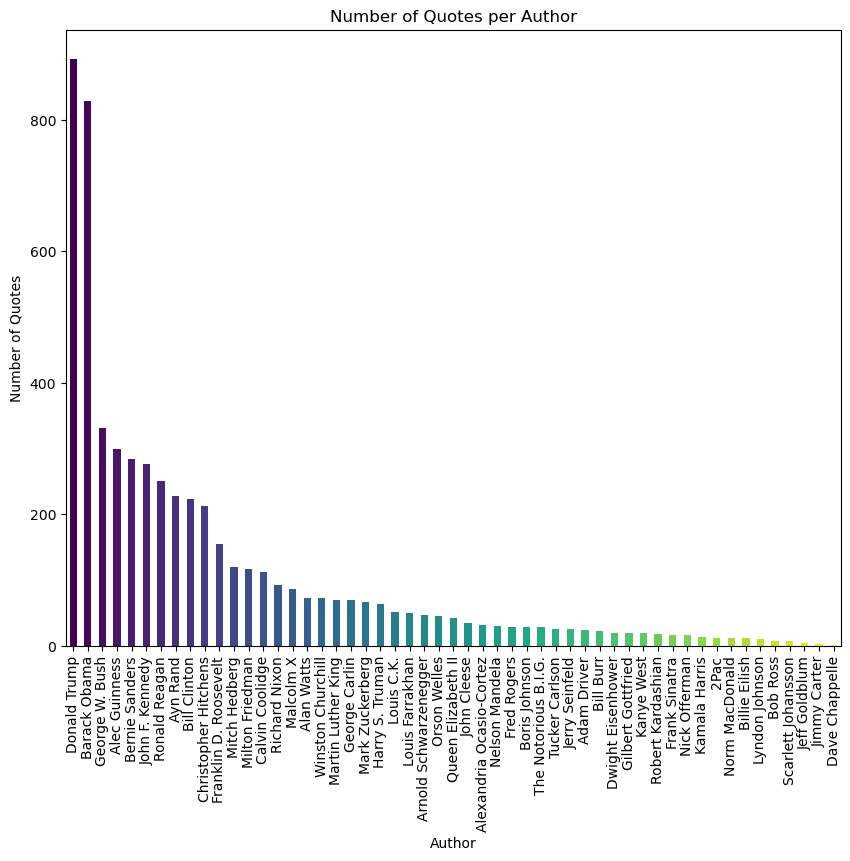

In [127]:
quotes_count_wiki = plot_author_quotes_count(data)

In [128]:
min_length = data['length'].min()
max_length = data['length'].max()
average_length = data['length'].mean()

print(f"Minimum length of quotes: {min_length}")
print(f"Maximum length of quotes: {max_length}")
print(f"Average length of quotes: {average_length:.2f}")

Minimum length of quotes: 2
Maximum length of quotes: 588
Average length of quotes: 151.20


### Data from hugging face used in:
Paper: Goel, S., Madhok, R., & Garg, S. (2018). Proposing Contextually Relevant Quotes for Images. Advances in Information Retrieval. Springer. doi: 10.1007/978-3-319-76941-7_49


Repo card metadata block was not found. Setting CardData to empty.


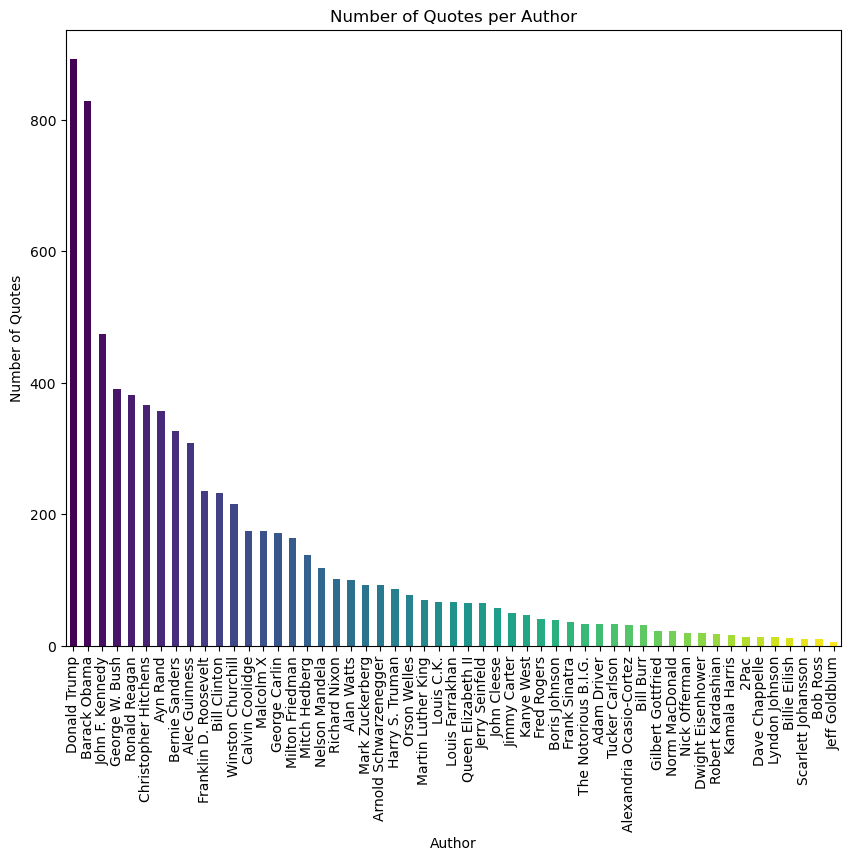

author_name
Donald Trump                892
Barack Obama                828
John F. Kennedy             474
George W. Bush              391
Ronald Reagan               381
Christopher Hitchens        366
Ayn Rand                    357
Bernie Sanders              326
Alec Guinness               308
Franklin D. Roosevelt       235
Bill Clinton                233
Winston Churchill           215
Calvin Coolidge             174
Malcolm X                   174
George Carlin               171
Milton Friedman             164
Mitch Hedberg               138
Nelson Mandela              119
Richard Nixon               102
Alan Watts                  100
Mark Zuckerberg              93
Arnold Schwarzenegger        92
Harry S. Truman              87
Orson Welles                 78
Martin Luther King           70
Louis C.K.                   67
Louis Farrakhan              66
Queen Elizabeth II           65
Jerry Seinfeld               65
John Cleese                  57
Jimmy Carter                

In [129]:
from datasets import load_dataset
ds = load_dataset("jstet/quotes-500k")
df_train = ds['train'].to_pandas()
df_train.rename(columns={'author': 'author_name'}, inplace=True)
def add_quotes_to_data(data, quotes_df, author_id_map):
    filtered_quotes_df = quotes_df[quotes_df['author_name'].isin(author_id_map.keys())]
    filtered_quotes_df = filtered_quotes_df[(filtered_quotes_df['author_name'] != 'Barack Obama') & (filtered_quotes_df['author_name'] != 'Donald Trump')]
    new_data = pd.DataFrame({
        'label': filtered_quotes_df['author_name'].map(author_id_map),
        'author_name': filtered_quotes_df['author_name'],
        'text': filtered_quotes_df['quote'],
        'type': 'bona-fide',
        'length': filtered_quotes_df['quote'].apply(len)
    })
    data = pd.concat([data, new_data], ignore_index=True)
    return data

data = add_quotes_to_data(data, df_train, author_id_map)
quotes_count_wiki = plot_author_quotes_count(data)
quotes_count_wiki

Number of authors that have more then 100 quotes: 9


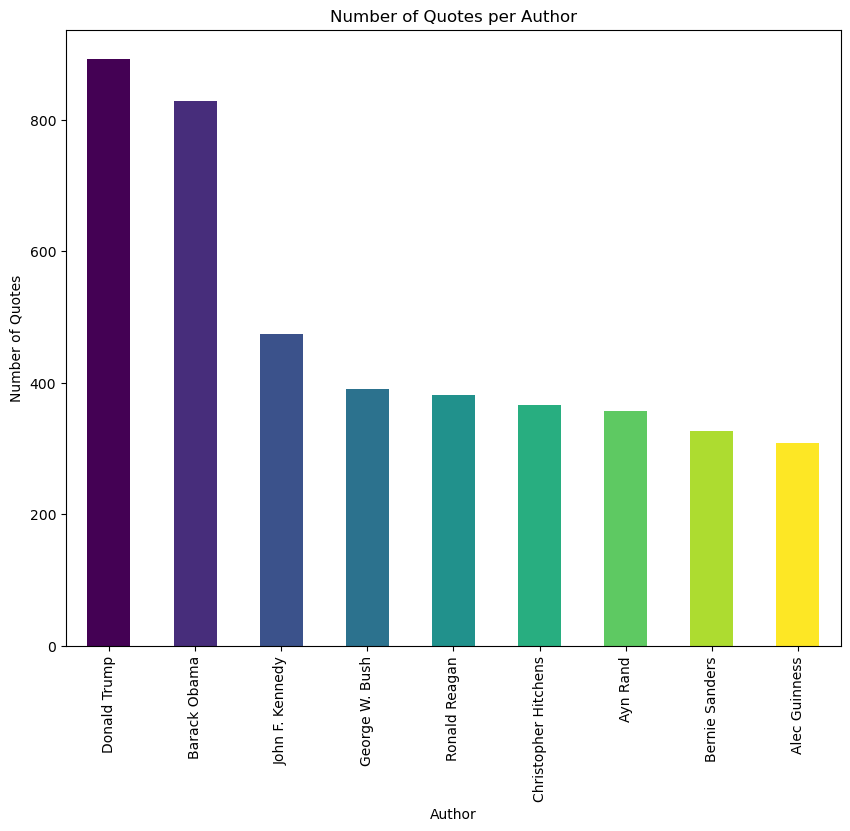

author_name
Donald Trump            892
Barack Obama            828
John F. Kennedy         474
George W. Bush          391
Ronald Reagan           381
Christopher Hitchens    366
Ayn Rand                357
Bernie Sanders          326
Alec Guinness           308
Name: count, dtype: int64

In [130]:
label_counts = data['label'].value_counts()
labels_to_keep = label_counts[label_counts >= 250].index
data_more_250 = data[data['label'].isin(labels_to_keep)]
print(f"Number of authors that have more then 100 quotes: {len(data_more_250['label'].unique())}")
plot_author_quotes_count(data_more_250)

In [131]:
data.to_csv('../Data/WikiQuotes_final.csv', index=False)

In [16]:
import pandas as pd
df = pd.read_csv('../../Data/WikiQuotes.csv')


In [17]:
unique_pairs = df[['label', 'author_name']].drop_duplicates()
unique_pairs


,label,author_name
0,0,Donald Trump
1,1,Franklin D. Roosevelt
3,2,Barack Obama
4,3,Bernie Sanders
8,4,Ayn Rand
14,5,Alec Guinness
16,6,Bill Clinton
19,7,George W. Bush
32,8,Ronald Reagan
34,9,John F. Kennedy


In [2]:
import pandas as pd
df = pd.read_csv('../Data/WikiQuotes.csv')

In [3]:
df

,label,author_name,text,type,length
0,0,Donald Trump,"In fact, dead people.",bona-fide,22
1,1,Franklin D. Roosevelt,and the local government's act for whiz.,bona-fide,41
2,0,Donald Trump,But I have made clear our trade imbalance is ...,bona-fide,66
3,2,Barack Obama,under very difficult circumstances is far gre...,bona-fide,110
4,3,Bernie Sanders,in the modern history of the United States of...,bona-fide,86
...,...,...,...,...,...
4616,10,Winston Churchill,"If we open a quarrel between past and present,...",bona-fide,90
4617,10,Winston Churchill,"It is always wise to look ahead, but difficult...",bona-fide,80
4618,10,Winston Churchill,The empires of the future are the empires of t...,bona-fide,54
4619,8,Ronald Reagan,"While I take inspiration from the past, like m...",bona-fide,83


In [12]:
df['length'].describe()

count    4621.000000
mean      157.329582
std       122.682359
min        21.000000
25%        59.000000
50%       116.000000
75%       231.000000
max       599.000000
Name: length, dtype: float64

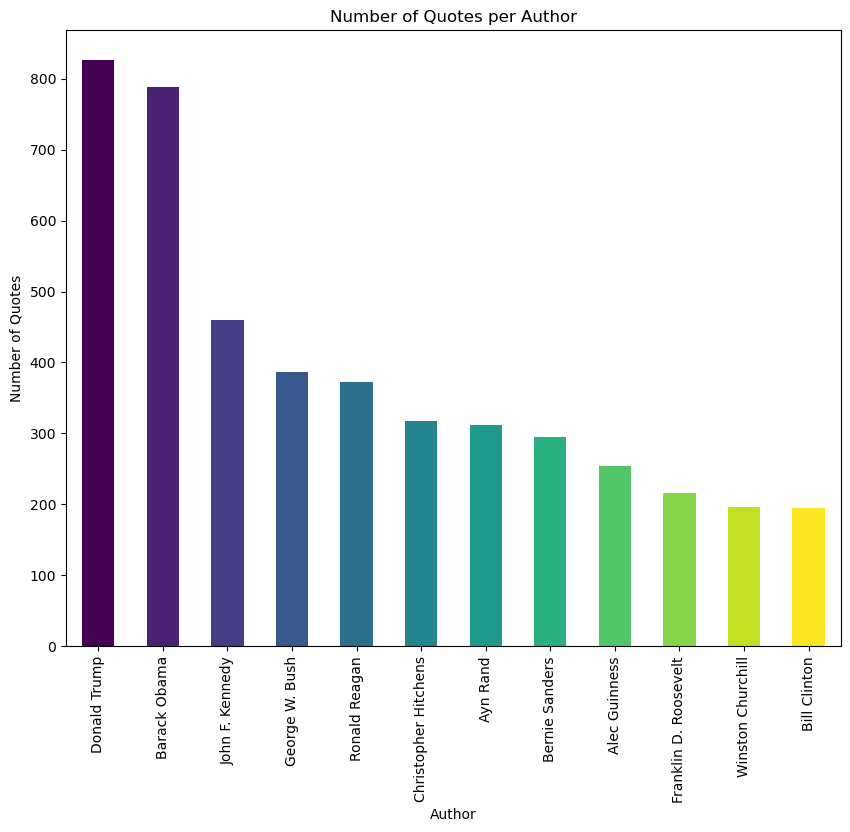

author_name
Donald Trump             827
Barack Obama             788
John F. Kennedy          460
George W. Bush           387
Ronald Reagan            373
Christopher Hitchens     318
Ayn Rand                 312
Bernie Sanders           295
Alec Guinness            254
Franklin D. Roosevelt    216
Winston Churchill        196
Bill Clinton             195
Name: count, dtype: int64

In [22]:
plot_author_quotes_count(df)

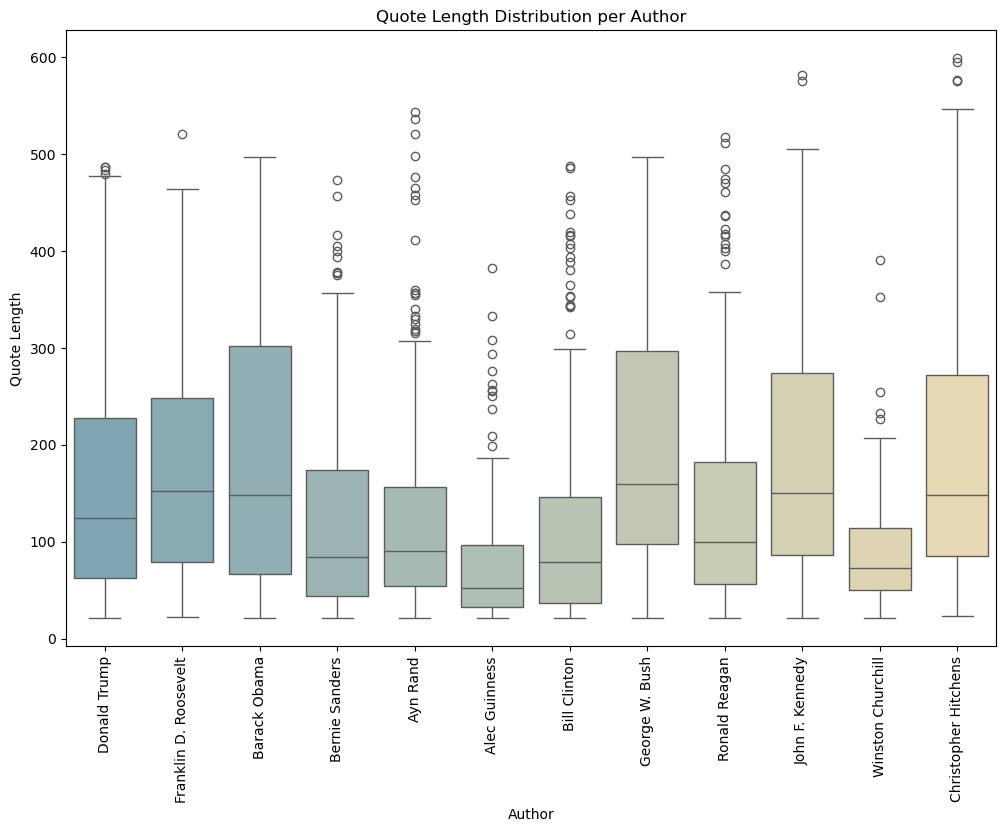

<Figure size 640x480 with 0 Axes>

In [21]:
import seaborn as sns
def plot_quotes_stats(data):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='author_name', y='length', data=data, palette='blend:#7AB,#EDA', hue='author_name')
    plt.title('Quote Length Distribution per Author')
    plt.xlabel('Author')
    plt.ylabel('Quote Length')
    plt.xticks(rotation=90)
    plt.show()
    # plt.savefig('quote_length_distribution.png')
    
plot_quotes_stats(df)